In [1]:
from pathlib import Path
import pickle
import random

from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [39]:
%%time
import os
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists('data/embeddings'):
    os.mkdir('data/embeddings')
if not os.path.exists('GDriveDL.py'):
    !wget https://raw.githubusercontent.com/matthuisman/gdrivedl/master/gdrivedl.py -O GDriveDL.py
if not os.path.exists('data/embeddings/missing_steps.pkl'):
    !python GDriveDL.py https://drive.google.com/open?id=1xe61xauPhF7pI6iBGxL8y3hdJnUim2qa data/embeddings
if not os.path.exists('data/embeddings/RuBERT_max_embeddings_long.pkl'):
    !python GDriveDL.py https://drive.google.com/open?id=1F8Njpfs1vrv9KitfqJ39exJUvGP-r1Zj data/embeddings
if not os.path.exists('data/embeddings/RuBERT_mean_embeddings_long.pkl'):
    !python GDriveDL.py https://drive.google.com/open?id=1xWXWf2244nq8PWVWDq5T_GGQz9w0QB1w data/embeddings
if not os.path.exists('data/embeddings/RuBERT_max_embeddings_short.pkl'):
    !python GDriveDL.py https://drive.google.com/open?id=1OxQi2Sd1bRMCV_Ms2RBLX3u4H8VqM3pC data/embeddings
if not os.path.exists('data/embeddings/RuBERT_mean_embeddings_short.pkl'):
    !python GDriveDL.py https://drive.google.com/open?id=1rtgoSSYnFNV4tPA-pZRxjXUTKubFkZIv data/embeddings
if not os.path.exists('data/russianfood.zip'):        
    !python GDriveDL.py https://drive.google.com/open?id=1dZzUGmu8tQOduIr4vo933hFj9YGam-P3 data    
    !unzip -q data/russianfood.zip -d data
if not os.path.exists('df_gan.zip'):        
    !python GDriveDL.py https://drive.google.com/open?id=1KKAqwSbHd-_qMpOAjYdbBRCh4M-HbRTH .
    !unzip -q df_gan.zip

^C


In [ ]:
# df_gan module is based on DF-GAN by Ming Tao (https://github.com/tobran/DF-GAN)
from df_gan.model import NetG, NetD

### 1) Dataset

In [3]:
class RecipeDataset(data.Dataset):
    def __init__(self, data_dir='data', 
                 split='train',
                 split_size = 0.9,
                 embeddings = 'RuBERT_mean_embeddings_long',
                 embeddings_type = 'whole_recipe',
                 base_size=64,
                 transform=None, target_transform=None):
        self.transform = transform
        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.target_transform = target_transform
        
        self.data_dir = Path(data_dir)
        self.split = split
        self.split_size = split_size
        
        self.embeddings_filename = embeddings
        self.embeddings_type = embeddings_type
        
        self.data = self.load_recipe_dataset()
        
        self.embeddings = self.load_embeddings()
        self.ids, self.filenames, self.recipes = self.load_data()

        self.class_id = np.arange(len(self.filenames))

    def load_recipe_dataset(self):
        data = pd.read_csv(self.data_dir / 'russianfood_filtred.csv')
        dataset_size = int(len(data) * self.split_size)
        data = data.head(dataset_size) if self.split == 'train' else data.tail(dataset_size)
        return data
    
    def load_embeddings(self):
        with open(self.data_dir / f'embeddings/{self.embeddings_filename}.pkl', 'rb') as f:
            embeddings_from_file = pickle.load(f)
            
        embeddings = {}
        # оставляем только нужные эмбеддинги
        for k, v in embeddings_from_file.items():
            embeddings[k] = v[self.embeddings_type]
        return embeddings
    
    def load_data(self):
        ''' Загружаем названием рецепта (на всякий случай) и последнее изображение
        тут учитываем, что у нас могут быть эмбеддинги не для всех рецептов
        '''
        self.data['has_embeddings'] = self.data.id.apply(lambda idx: idx in self.embeddings)
        self.data = self.data[self.data.has_embeddings]
        ids = list(self.data.id.values)
        filenames = list(map(lambda x: x.split('|')[-1], self.data.images.values))
        recipes = list(self.data.title.values)
        return ids, filenames, recipes

    def __getitem__(self, index):
        #
        key = self.filenames[index]
        cls_id = self.class_id[index]
       
        # Загружаем изображение
        img_path = self.data_dir / key  
        img = Image.open(img_path).convert('RGB')
        width, height = img.size
        if self.transform is not None:
            img = self.transform(img)
        imgs = []
        imgs.append(self.norm(img))
        
        # ИСПРАВИТЬ - временно для того чтобы проверить работоспособность в целом
        embs = self.embeddings[self.ids[index]][:256]
        
        return imgs, embs, cls_id, key
    
    def __len__(self):
        return len(self.filenames)

In [7]:
embeddings = 'RuBERT_mean_embeddings_long'
embeddings_type = 'whole_recipe'
train_data = RecipeDataset(split = 'train', split_size=0.9, embeddings=embeddings, embeddings_type=embeddings_type)

#### Посмотрим что получилось:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[134548, 114586, 145246, 146924, 148257]
['Торт без выпечки, с творогом и черносливом', 'Курица в сливках с черносливом', 'Чесночная картошка "Объедение" в духовке', 'Жареные помидоры', 'Варёные яйца в виде поросят']
['images/134548_4.jpg', 'images/114586_8.jpg', 'images/145246_8.jpg', 'images/146924_7.jpg', 'images/148257_10.jpg']
11363


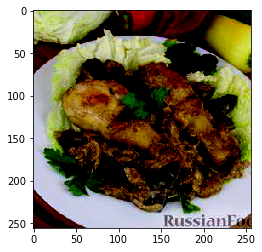

In [8]:
print(train_data.ids[:5])
print(train_data.recipes[:5])
print(train_data.filenames[:5])
print(len(train_data))
imshow(train_data[1][0][0].numpy().transpose(1, 2, 0))

## 2) Обучение

In [9]:
seed = 100
print("seed now is : ", seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
cudnn.benchmark = True

seed now is :  100


In [10]:
device

device(type='cuda')

#### Config:

In [27]:
config = {}

config['CUDA'] = True
config['WORKERS'] = 4

config['loss'] = 'hinge'
config['BASE_SIZE'] = 64

config['DATASET'] = {}
config['DATASET']['EMBEDDINGS_FILE'] = 'RuBERT_mean_embeddings_long'
config['DATASET']['EMBEDDINGS_TYPE'] = 'whole_recipe'


config['TRAIN'] = {}
config['TRAIN']['BATCH_SIZE'] = 8
config['TRAIN']['MAX_EPOCH'] = 2
config['TRAIN']['SNAPSHOT_INTERVAL'] = 2000
config['TRAIN']['DISCRIMINATOR_LR'] = 2e-4
config['TRAIN']['GENERATOR_LR'] = 2e-4
config['TRAIN']['ENCODER_LR'] = 2e-4
# config['TRAIN']['RNN_GRAD_CLIP'] = 0.25
# config['TRAIN']['FLAG'] = True
# config['TRAIN']['NET_E'] = ''
# config['TRAIN']['NET_G'] = ''
# config['TRAIN']['B_NET_D'] = True
config['TRAIN']['NF'] = 32
config['TRAIN']['SMOOTH'] = {}
config['TRAIN']['SMOOTH']['GAMMA1'] = 5.0
config['TRAIN']['SMOOTH']['GAMMA1'] = 10.0
config['TRAIN']['SMOOTH']['GAMMA1'] = 5.0
config['TRAIN']['SMOOTH']['GAMMA1'] = 1.0

config['GAN'] = {}
config['GAN']['DF_DIM'] = 64
config['GAN']['GF_DIM'] = 128
config['GAN']['Z_DIM'] = 100
config['GAN']['CONDITION_DIM'] = 100
config['GAN']['R_NUM'] = 2
config['GAN']['B_ATTENTION'] = True
config['GAN']['B_DCGAN'] = True

In [28]:
imsize = 64

# dataset and dataloader

image_transform = transforms.Compose([
    transforms.Resize(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])

   
dataset = RecipeDataset(split = 'train', split_size=0.9,
                        embeddings=config['DATASET']['EMBEDDINGS_FILE'],
                        embeddings_type=config['DATASET']['EMBEDDINGS_TYPE'])

print(len(dataset))
assert dataset
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config['TRAIN']['BATCH_SIZE'], drop_last=True,
    shuffle=True, num_workers=config['WORKERS'])

11363


In [29]:
def prepare_data(data):
    imgs, embds, class_ids, keys = data

    real_imgs = []
    for i in range(len(imgs)):
        if config['CUDA']:
            real_imgs.append(Variable(imgs[i]).cuda())
        else:
            real_imgs.append(Variable(imgs[i]))

    if config['CUDA']:
        embds = Variable(embds).cuda()
    else:
        embds = Variable(embds)

    return [real_imgs, embds, class_ids, keys]

In [30]:
def train(dataloader, netG, netD, optimizerG, optimizerD, state_epoch, batch_size, device):
    fake_images = Path('fake_images')
    fake_images.mkdir(exist_ok=True)
    for epoch in range(state_epoch + 1, config['TRAIN']['MAX_EPOCH'] + 1):
        for step, data in enumerate(dataloader, 0):
    
            imags, sent_emb, class_ids, keys = prepare_data(data)
#             hidden = text_encoder.init_hidden(batch_size)
#             # words_embs: batch_size x nef x seq_len
#             # sent_emb: batch_size x nef
#             words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
#             words_embs, sent_emb = words_embs.detach(), sent_emb.detach()

            imgs=imags[0].to(device)
            real_features = netD(imgs)
            output = netD.COND_DNET(real_features, sent_emb)
            errD_real = torch.nn.ReLU()(1.0 - output).mean()

            output = netD.COND_DNET(real_features[:(batch_size - 1)], sent_emb[1:batch_size])
            errD_mismatch = torch.nn.ReLU()(1.0 + output).mean()

            # synthesize fake images
            noise = torch.randn(batch_size, 100)
            noise=noise.to(device)
            fake = netG(noise,sent_emb)  
            
            # G does not need update with D
            fake_features = netD(fake.detach()) 

            errD_fake = netD.COND_DNET(fake_features,sent_emb)
            errD_fake = torch.nn.ReLU()(1.0 + errD_fake).mean()          

            errD = errD_real + (errD_fake + errD_mismatch)/2.0
            optimizerD.zero_grad()
            optimizerG.zero_grad()
            errD.backward()
            optimizerD.step()

            #MA-GP
            interpolated = (imgs.data).requires_grad_()
            sent_inter = (sent_emb.data).requires_grad_()
            features = netD(interpolated)
            out = netD.COND_DNET(features,sent_inter)
            grads = torch.autograd.grad(outputs=out,
                                    inputs=(interpolated,sent_inter),
                                    grad_outputs=torch.ones(out.size()).cuda(),
                                    retain_graph=True,
                                    create_graph=True,
                                    only_inputs=True)
            grad0 = grads[0].view(grads[0].size(0), -1)
            grad1 = grads[1].view(grads[1].size(0), -1)
            grad = torch.cat((grad0,grad1),dim=1)                        
            grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
            d_loss_gp = torch.mean((grad_l2norm) ** 6)
            d_loss = 2.0 * d_loss_gp
            optimizerD.zero_grad()
            optimizerG.zero_grad()
            d_loss.backward()
            optimizerD.step()
            
            # update G
            features = netD(fake)
            output = netD.COND_DNET(features,sent_emb)
            errG = - output.mean()
            optimizerG.zero_grad()
            optimizerD.zero_grad()
            errG.backward()
            optimizerG.step()

            print('[%d/%d][%d/%d] Loss_D: %.3f Loss_G %.3f'
                % (epoch, config['TRAIN']['MAX_EPOCH'], step, len(dataloader), errD.item(), errG.item()))

        vutils.save_image(fake.data,
                          fake_images / f'{epoch}.png',
                          normalize=True)

#         if epoch%10==0:
#             torch.save(netG.state_dict(), 'models/%s/netG_%03d.pth' % (cfg.CONFIG_NAME, epoch))
#             torch.save(netD.state_dict(), 'models/%s/netD_%03d.pth' % (cfg.CONFIG_NAME, epoch))       

In [31]:
netG = NetG(config['TRAIN']['NF'], 100).to(device)
netD = NetD(config['TRAIN']['NF']).to(device)

state_epoch=0

optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0004, betas=(0.0, 0.9))

In [32]:
train(dataloader, netG, netD, optimizerG, optimizerD, state_epoch, config['TRAIN']['BATCH_SIZE'], device)

BrokenPipeError: [Errno 32] Broken pipe